# Question 2: applied ML

In [200]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.mlab as mlab
import sklearn.datasets
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from pprint import pprint
import random
%matplotlib inline

## Preprocessing of the newspaper dataset

#### Loading of the newspaper dataset

Firstly we load the newspaper standard dataset from the sklearn library and we print the newspapers categories (targets) that are used for classification in this problem.

In [201]:
newsgroups= fetch_20newsgroups(subset ='all')
pprint(type(newsgroups))
pprint(dir(newsgroups))
len(newsgroups.target)

<class 'sklearn.utils.Bunch'>
['DESCR', 'data', 'description', 'filenames', 'target', 'target_names']


18846

#### Training, validation and test set generation

In this part we randomly divide the dataset in three parts as follows:
- Train set: constituting 80% of the original dataset
- Validation set: constituting 10% of the original dataset
- Test set: constituting 10% of the original dataset

Firstly we get the number of data that will be in each set.

In [202]:
train_ratio = 0.8
test_ratio = 0.1
valid_ratio = 0.1

data_len = len(newsgroups.filenames)
train_len = int(np.floor(train_ratio*data_len))
test_len = int(np.floor(test_ratio*data_len))
valid_len = int(data_len - (train_len + test_len))

Then we use the shuffle function from the random package to shuffle indices and therefore to randomly attribute the observed data to each of the three subsets.

In [203]:
rand_articles = [i for i in range(data_len)]

random.seed(2)
random.shuffle(rand_articles)

train_subset = rand_articles[0:train_len]
test_subset = rand_articles[train_len:train_len+test_len]
valid_subset = rand_articles[train_len+test_len:]

#### TF-IDF computation

Now we compute the TF-IDF statistic for the newspaper dataset. To do so we use the `TfidfVectorizer()` function from the `sklearn` library.

In [204]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(newsgroups.data)


In the following part we just assign the vectors obtained in the previous step to the train, test and training set.

In [205]:
train_vectors = vectors[train_subset,:]
test_vectors = vectors[test_subset,:]
valid_vectors = vectors[valid_subset,:]

train_target = [newsgroups.target[w] for w in train_subset]
test_target = [newsgroups.target[w] for w in test_subset]
valid_target = [newsgroups.target[w] for w in valid_subset]

## Random Forest Training 

#### Grid search

Now we compute train a random forest classifier for different combination of parameters. The parameters that are investigated are:
- The number of decision trees generated in order to build the random forest.
- The maximum depth of each of those decision trees

To do so we implement a grid search over the parameters. Therefore we train a random forest for each parameter combination in a two nested for loops. While training random forests for the different combinations of parameters we also compute the train score and the validation score. The validation score will be useful afterwards to select the parameter combination that yields the best prediction. 

The score computed in this part is the default score implemented in the sklearn classifier for Random Forests: it is the mean accuracy.

In [78]:
parameters = {'n_estimators': [100, 300, 400, 500] , 'max_depth':[25, 30, 35, 40, 45]}
train_score = np.zeros((len(parameters['n_estimators']), len(parameters['max_depth'])))
valid_score = np.zeros((len(parameters['n_estimators']), len(parameters['max_depth'])))

for index_estim, n_estimators in enumerate(parameters['n_estimators']):
    for index_depth, max_depth in enumerate(parameters['max_depth']):
        rand_forest = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, verbose = 1)
        rand_forest.fit(train_vectors, train_target)
        train_score[index_estim, index_depth] = rand_forest.score(train_vectors, train_target)
        valid_score[index_estim, index_depth] = rand_forest.score(valid_vectors, valid_target)

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   11.2s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   14.8s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   17.8s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   22.2s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   25.7s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]

The scores obtained for the training set and the test set are the following:

In [206]:
valid_score

array([[ 0.77889714,  0.78844115,  0.7990456 ,  0.79745493,  0.80965005],
       [ 0.79374337,  0.81018028,  0.81972428,  0.81919406,  0.82502651],
       [ 0.7921527 ,  0.81177094,  0.81654295,  0.82926829,  0.83297985],
       [ 0.79321315,  0.81707317,  0.82396607,  0.82661718,  0.83191941]])

In [207]:
train_score

array([[ 0.9225922 ,  0.94421597,  0.96113027,  0.97366676,  0.98023348],
       [ 0.94235872,  0.96026798,  0.97174317,  0.9806978 ,  0.98640223],
       [ 0.94229239,  0.96132927,  0.97273813,  0.98102945,  0.98726453],
       [ 0.94733351,  0.9637835 ,  0.97459538,  0.98182542,  0.98772884]])

#### Heat maps of the scores

Now we plot both the validation score and the train score thanks to heat maps. The validation is going to help us choosing the combination of parameters that maximizes the mean accuracy. The train score heat map is just plot to confirm that the train error decreases as both the max tree depth and the number of trees increase.

In [208]:
parameters['max_depth']

[25, 30, 35, 40, 45]

Text(0.5,1,'Train score')

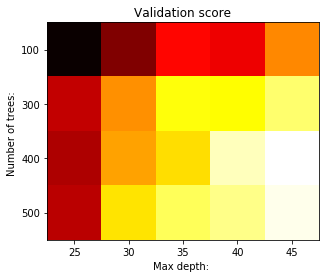

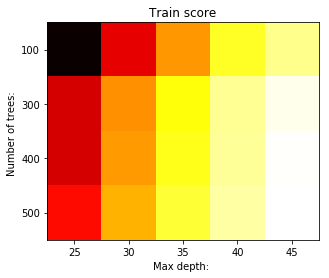

In [209]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots()
# We need to draw the canvas, otherwise the labels won't be positioned and 
# won't have values yet.
fig.canvas.draw()
plt.imshow(valid_score, cmap='hot')
ax.set_yticklabels([''] + parameters['n_estimators'])
ax.set_xticklabels([''] + parameters['max_depth'])
plt.xlabel('Max depth: ')
plt.ylabel('Number of trees: ')
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.title('Validation score')

fig, ax = plt.subplots()
# We need to draw the canvas, otherwise the labels won't be positioned and 
# won't have values yet.
fig.canvas.draw()
plt.imshow(train_score, cmap='hot')
ax.set_yticklabels([''] + parameters['n_estimators'])
ax.set_xticklabels([''] + parameters['max_depth'])
plt.xlabel('Max depth: ')
plt.ylabel('Number of trees: ')
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.title('Train score')

#### Parameter selection

The cell below shows the best combination that yields the least validation error over the tested parameters:

In [210]:
ravel_index = np.argmax(valid_score)
best_n_estimators_index = int(ravel_index / valid_score.shape[1])
best_max_depth_index = ravel_index % valid_score.shape[1]

best_n_estimators = parameters['n_estimators'][best_n_estimators_index]
best_max_depth = parameters['max_depth'][best_max_depth_index]

print('The best number of trees is:', best_n_estimators)
print('The best maximal tree depth is:', best_max_depth)
print('With a validation score of:', valid_score[best_n_estimators_index, best_max_depth_index])
print('And a train score of:', train_score[best_n_estimators_index, best_max_depth_index])

The best number of trees is: 400
The best maximal tree depth is: 45
With a validation score of: 0.832979851538
And a train score of: 0.9872645264


#### Pseudo optimal random forest training

Now we train again a random forest classifier on our training data with those pseudo optimal parameters in order to be able to carry out prediction with it.

In [ ]:
opt_rand_forest = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth, verbose = 1)
opt_rand_forest.fit(train_vectors, train_target)

#### Test score

Now we are able to compute the score of the optimized random forest.

In [ ]:
test_score = opt_rand_forest.score(test_vectors, test_target)
print('The test score is:', test_score)

We can remark that the test score is less than both the validation and train scores. This is conformed with what we could expect given that the model is trained from train set and then 

In [ ]:
y_pred_test = opt_rand_forest.predict(test_vectors)
confusion_matrix = sklearn.metrics.confusion_matrix(test_target, y_pred_test, labels=range(20), sample_weight=None)
confusion_matrix.shape

Here we modify the confusion matrix so that each of its rows are normalized according to the number of true elements of each label in the test set.

In [ ]:
div = confusion_matrix.sum(axis=1)
div = np.column_stack([div]*20)
normalized_confusion = confusion_matrix / div

Now that the confusion matrix is normalized we plot it along with a dictionary of the class indices in order to better read the plot.

In [ ]:
labels = list(newsgroups.target_names)
[print(x,'->',labels[x]) for x in range(20)]
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111)
plot = ax.matshow(normalized_confusion)
fig.colorbar(plot)
plt.title('Normalized confusion matrix of the Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')


The confusion matrix graphically shows that the classifier is a good prediction model. Indeed we can see that the diagonal elements of the matrix show much higher ratios than the non diagonal elements. It shows that the number of true answers is quite high.

## Feature analyzis

The idea now is to analyze the features that had the greatest important when constructing the decision trees of the random forest. Every feature is assigned a score in the `feature_importances_`'s attribute of RandomForest. Therefore we are going to use this attribute in order to get the words that were the most used in order to classify the newspapers.

In [179]:
feat_imp = opt_rand_forest.feature_importances_
feat_serie = pd.Series(feat_imp)
sorted_feat_serie = feat_serie.sort_values(ascending = False).head(20)
sorted_feat_serie

46061     0.005640
165812    0.005572
55485     0.005127
65684     0.004817
139570    0.004690
80391     0.004252
52100     0.004173
85770     0.004093
145613    0.003817
92333     0.003498
41895     0.003209
44285     0.003203
69924     0.003128
116858    0.003078
52328     0.003054
54421     0.002999
78332     0.002993
82049     0.002770
71043     0.002754
151673    0.002704
dtype: float64

Above we have the 20 features that served the most for classifying the data. We are now going to retrieve the real English word behind the indices.

In [180]:
[vectorizer.get_feature_names()[x] for x in sorted_feat_serie.index]



['bike',
 'windows',
 'clipper',
 'dod',
 'sale',
 'god',
 'car',
 'hockey',
 'space',
 'israel',
 'athos',
 'baseball',
 'encryption',
 'nhl',
 'cars',
 'christian',
 'game',
 'gun',
 'escrow',
 'team']

Therefore above we have the 20 features that helped the most classifying our dataset of documents in the 20 classes defined in `newsgroups.target_names`.